In [1]:
pwd

'c:\\Users\\DELL\\OneDrive\\Desktop\\Project\\Automated YouTube Mixtape Creation with Python\\experiment_notebook'

In [2]:
from pydub import AudioSegment

In [3]:
audio= AudioSegment.from_file('song.mp3')

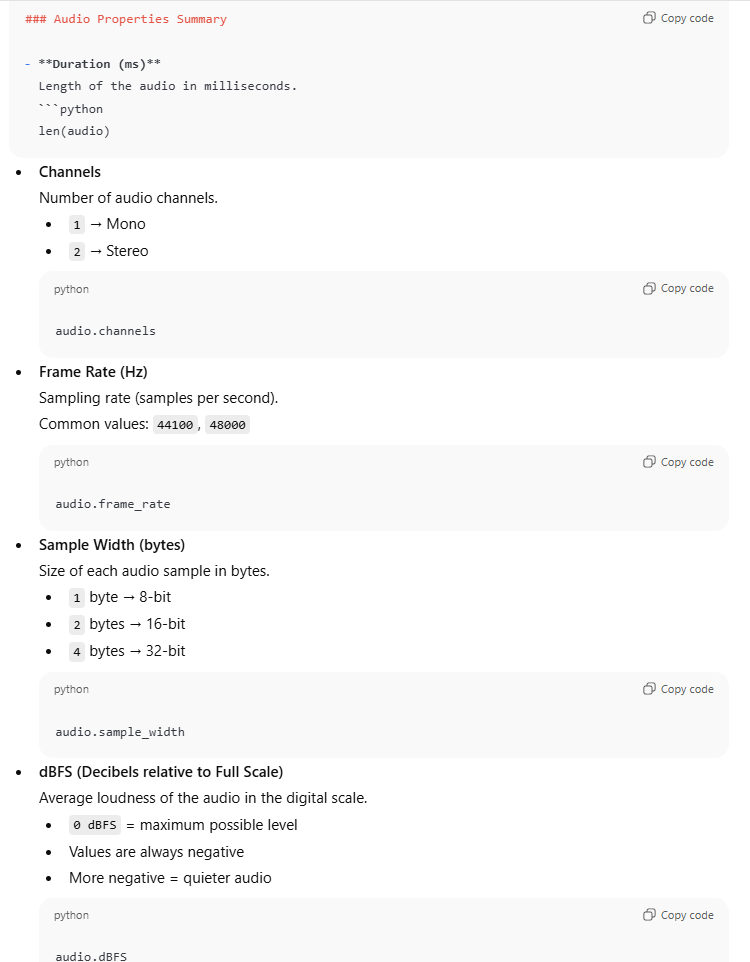

In [4]:
print("DUration (ms):", len(audio))
print("Channels:" ,audio.channels)
print("frame Rate:" ,audio.frame_rate)
print("Sample Weight (bytes):", audio.sample_width)
print("DBFS (average loudness):", audio.dBFS)

DUration (ms): 283144
Channels: 2
frame Rate: 44100
Sample Weight (bytes): 2
DBFS (average loudness): -17.27181331425538


2. Slicing Audio (Show Output Sizes)

In [5]:
first_5_sec =audio[:5000]
next_5_sec =audio[5000:10000]

print("First 5 sec duration", len(first_5_sec))
print("Next 5 sec:",len(next_5_sec))


First 5 sec duration 5000
Next 5 sec: 5000


3.Fade In / Fade Out Demo

In [6]:
fade_in_clip =audio[:5000].fade_in(3000)
fade_out_clip=audio[:5000].fade_out(3000)

print("Fade-in clip:", fade_in_clip)
print("Fade_out clip",fade_out_clip)

Fade-in clip: <pydub.audio_segment.AudioSegment object at 0x0000023305E2DC90>
Fade_out clip <pydub.audio_segment.AudioSegment object at 0x0000023305E2F160>


4.Concatenation Demo

In [7]:
combined = first_5_sec + next_5_sec
print("Combined length:", len(combined))

Combined length: 10000


6.SIMPLE Waveform Plot Using Librosa + Matplotlib

c:\Users\DELL\OneDrive\Desktop\Project\Automated YouTube Mixtape Creation with Python\djenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


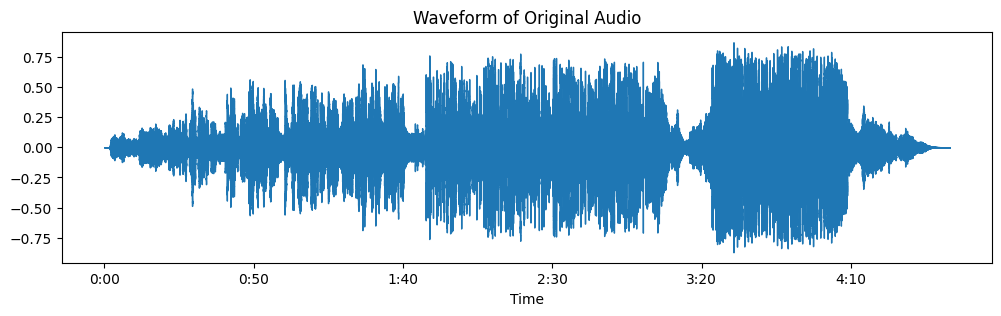

In [8]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

y, sr=librosa.load("song.mp3",sr=None)#sr=sampling rate

plt.figure(figsize=(12,3))
librosa.display.waveshow(y,sr=sr)
plt.title("Waveform of Original Audio")
plt.show()

7.Visualize Fade-In vs Fade-Out

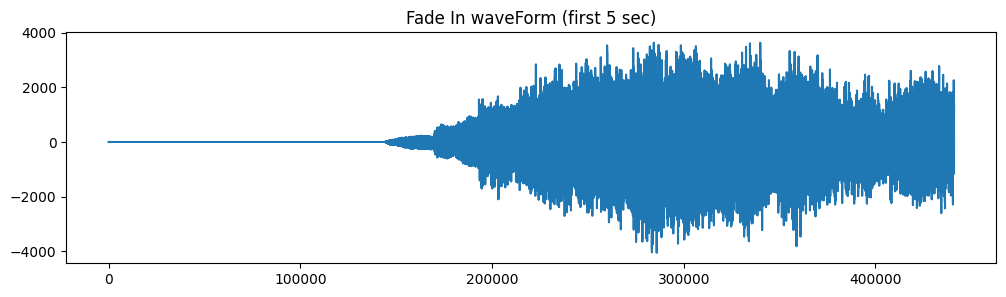

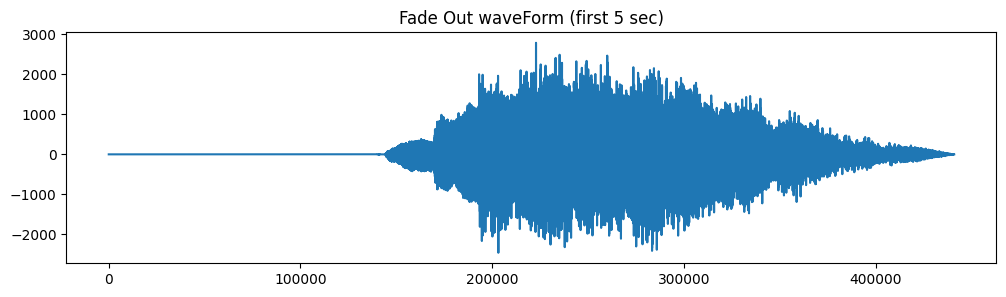

In [9]:
fade_in_audio= fade_in_clip.get_array_of_samples()
fade_out_audio= fade_out_clip.get_array_of_samples()

plt.figure(figsize=(12,3))
plt.plot(fade_in_audio)
plt.title('Fade In waveForm (first 5 sec)')
plt.show()

plt.figure(figsize=(12,3))
plt.plot(fade_out_audio)
plt.title('Fade Out waveForm (first 5 sec)')
plt.show()

Logic


In [10]:
import os
import json
import random
import subprocess
from pydub import AudioSegment, effects  # Normalization ke liye effects chahiye
from PIL import Image

def match_target_amplitude(sound, target_dBFS):
    """Gaane ki volume ko ek target level par set karne ke liye"""
    change_in_dBFS = target_dBFS - sound.dBFS
    return sound.apply_gain(change_in_dBFS)

print("✅ Setup and Normalization function ready!")

✅ Setup and Normalization function ready!


MIXTAPE Genrator

In [11]:
os.listdir('mixtape')

['Chahun Main Ya Naa  8D AUDIO   Aashiqui 2  Aditya Roy Kapur, Shraddha Kapoor.mp3',
 'titanic.mp3']

1. ek song uthao
2. agar pehla hai → seedha add
3. warna:
   - last ka thoda part lo
   - usko dheere dheere band karo
   - naye song ka starting part lo
   - usko dheere dheere start karo
   - dono ko mix karo
4. baaki song jod do
5. end me export



Smooth Fade Mixtape + ARTIFACT GENERATION

In [ ]:
def smooth_fade_mixtape(folder, output="output/mixtape.mp3", transition_ms=15000, shuffle=False):
    # Files scan aur sort
    files = [f for f in os.listdir(folder) if f.endswith((".mp3", ".wav"))]
    files.sort()
    if shuffle:
        random.shuffle(files)

    os.makedirs("output/artifacts", exist_ok=True)
    
    mix_tape = None
    timing_data = []
    current_time_ms = 0
    TARGET_LOUDNESS = -20.0 # Standard professional loudness level

    for idx, file in enumerate(files):
        song_path = os.path.join(folder, file)
        song = AudioSegment.from_file(song_path)
        
        # 1. Channels aur Frame Rate set karein
        song = song.set_channels(2).set_frame_rate(44100)
        
        # 2. LOUDNESS NORMALIZATION 
        song = match_target_amplitude(song, TARGET_LOUDNESS)
        
        song_duration = len(song)

        if mix_tape is None:
            mix_tape = song
            timing_data.append({"track": file, "start_ms": 0, "duration_ms": song_duration})
            current_time_ms += song_duration
        else:
            overlap = min(transition_ms, len(song), len(mix_tape))
            
            # Crossfade with Filters
            outgoing = mix_tape[-overlap:].fade_out(overlap).low_pass_filter(4000)
            incoming = song[:overlap].fade_in(overlap).low_pass_filter(4000)
            
            transition = outgoing.overlay(incoming)
            mix_tape = mix_tape[:-overlap] + transition + song[overlap:]
            
            # Timestamp calculation (Overlap aware)
            start_time = current_time_ms - overlap
            timing_data.append({"track": file, "start_ms": start_time, "duration_ms": song_duration})
            current_time_ms += (song_duration - overlap)

    # Export Mixtape
    mix_tape.export(output, format="mp3", bitrate="192k")
    
    # Save Artifacts
    with open("output/artifacts/timing.json", "w") as f:
        json.dump(timing_data, f, indent=4)
        
    print(f"✅ Normalized Mixtape created: {output}")
    return timing_data



✅ Normalized Mixtape created: output/mixtape.mp3


In [ ]:
smooth_fade_mixtape(
    folder="mixtape",
    transition_ms=15000,
   
)


✅ Normalized Mixtape created: output/mixtape.mp3


[{'track': 'Chahun Main Ya Naa  8D AUDIO   Aashiqui 2  Aditya Roy Kapur, Shraddha Kapoor.mp3',
  'start_ms': 0,
  'duration_ms': 305157},
 {'track': 'titanic.mp3', 'start_ms': 290157, 'duration_ms': 283144}]

DESCRIPTION GENERATOR

Generate YouTube Description (USING ARTIFACTS)

In [14]:
def generate_youtube_description_from_artifacts(
    timing_file="output/artifacts/timing.json",
    mixtape_name="Afro House Mixtape",
    genre="Afro House"
):
    with open(timing_file) as f:
        timing_data = json.load(f)

    description = f"🔥 {mixtape_name} 🔥\n"
    description += f"Genre: {genre}\n\n"
    description += "🎵 Tracklist:\n"

    for item in timing_data:
        start_sec = item["start_ms"] // 1000
        minutes = start_sec // 60
        seconds = start_sec % 60
        timestamp = f"{minutes:02d}:{seconds:02d}"

        track_name = os.path.splitext(item["track"])[0]
        description += f"{timestamp} - {track_name}\n"

    description += "\n🎧 Enjoy the mix & follow for more!\n"
    description += "#AfroHouse #HouseMusic #DJMix #Mixtape"

    return description


Generate & Save Description

In [15]:
description = generate_youtube_description_from_artifacts(
    mixtape_name="Afro House Summer Mix",
    genre="Afro House"
)

print(description)

with open("youtube_description.txt", "w", encoding="utf-8") as f:
    f.write(description)


🔥 Afro House Summer Mix 🔥
Genre: Afro House

🎵 Tracklist:
00:00 - Chahun Main Ya Naa  8D AUDIO   Aashiqui 2  Aditya Roy Kapur, Shraddha Kapoor
04:50 - titanic

🎧 Enjoy the mix & follow for more!
#AfroHouse #HouseMusic #DJMix #Mixtape


VIDEO GENERATOR

The function takes an image and an audio file, resizes the image to a fixed video resolution, and saves it temporarily. It then builds an FFmpeg command that loops the image, combines it with the audio, and encodes the result using H.264 video and AAC audio. A very low FPS and the ultrafast preset are used to make rendering extremely fast, since the visual is static. FFmpeg creates an MP4 video that lasts exactly as long as the audio. After the video is generated, the temporary resized image is deleted.

In [1]:
from moviepy import ImageClip, AudioFileClip
import os

def make_video_from_audio(image_path, audio_path, output_path="output/video.mp4"):
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    audio = AudioFileClip(audio_path)

    video = (
        ImageClip(image_path)
        .with_duration(audio.duration)   # ✅ correct
        .with_audio(audio)               # ✅ correct
    )

    video.write_videofile(output_path, fps=1)


In [2]:
make_video_from_audio(
    image_path="images/image.png",
    audio_path="output/mixtape.mp3"
)


MoviePy - Building video output/video.mp4.
MoviePy - Writing audio in videoTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
MoviePy - Writing video output/video.mp4



MoviePy - Done !
MoviePy - video ready output/video.mp4


Bilkul, isse aapke project ka roadmap ekdum clear ho jayega. Humne abhi tak wahi solve kiya hai jo code ko "error-free" banata hai, aur aage hum wo solve karenge jo usse "professional" banata hai.

Ye raha line-wise breakdown:

1. Pehle Kya Problem Thi? (The Issues)
Order Mismatch: Gaano ki list aur YouTube timestamps ka order alag ho raha tha.

Time Drift: Crossfade overlap ki wajah se timestamps dheere-dheere galat (late) ho rahe the.

Silent Video: Video bina awaaz ke ban rahi thi kyunki FFmpeg ko file milne se pehle video creation shuru ho rahi thi.

Stretched Images: Mixtape ki image video screen par khichi hui (badsurat) dikh rahi thi.

Logic Breaks: Agar mixtape folder mein koi extra file hoti, toh pura program crash ho jata tha.

2. Humne Kya Solve Kiya? (Current Fixes)
Single Source of Truth: timing.json file banayi jo audio aur description dono ke liye ek hi order fix karti hai.

Overlap-Aware Math: Timestamp calculate karte waqt overlap ko subtract kiya taaki time ekdum accurate rahe.

Pipeline Sync: Pehle audio export ko finish kiya, uske baad hi video creation call ki.

Smart Resizing: Image ka aspect ratio maintain karne ke liye padding aur centering logic add kiya.

Format Compatibility: FFmpeg mein yuv420p aur libmp3lame add kiya taaki video har device par chale.

3. Aage Kya Solve Karna Hai? (Future Improvements)
Loudness Normalization: Saare gaano ki volume ek standard level par set karna taaki listener ko baar-baar volume na badalni pade.

Beat-Matched Transitions: Fixed seconds ki jagah gaano ki "beats" analyze karke DJ jaisa smooth switch karna.

Metadata Embedding: MP3 file ke andar hi Artist ka naam, Title aur Thumbnail photo permanently save karna.

Error Resilience: Corrupt files ko auto-skip karna taaki ek galat gaane ki wajah se pura program na ruke.

Progress Indicators: Code run hote waqt screen par [1/10] Processing... jaisa status dikhana.

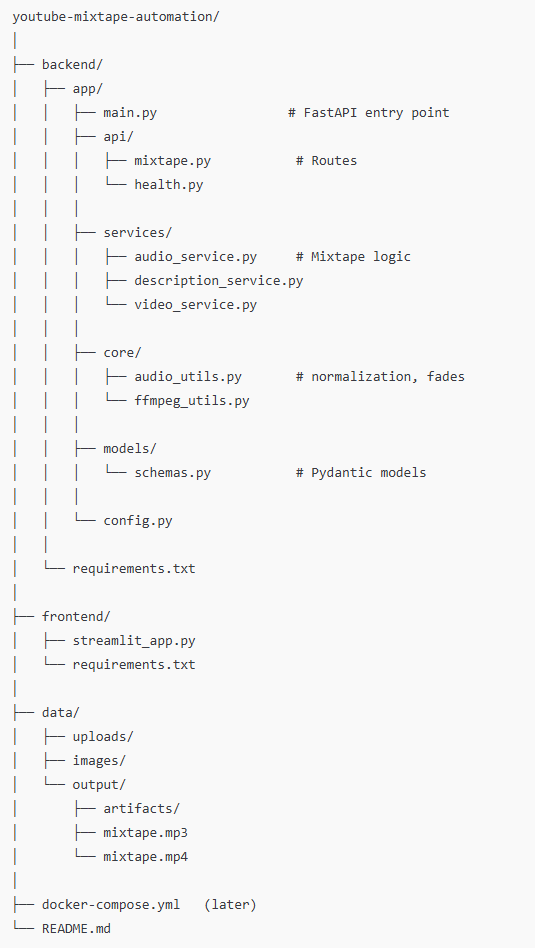